### 1) Import Lib

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
import joblib

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor


### 2) Data preprocessing

In [2]:
df = pd.read_csv("datasets/data.csv")
print(df.shape)
df.head(2)

(45593, 20)


,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33


In [3]:
df = df.drop(["ID", "Delivery_person_ID","Order_Date", "Time_Order_picked","multiple_deliveries"], axis=1)
# vì 1 số cột có dtype là object nên không thể đếm được count null
df.replace({"NaN": np.nan}, regex=True, inplace = True)
df.isnull().sum()

Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Time_Orderd                    1731
Weatherconditions               616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
Festival                        228
City                           1200
Time_taken(min)                   0
dtype: int64

In [4]:
df = df.dropna()
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42260 entries, 0 to 42259
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Delivery_person_Age          42260 non-null  object 
 1   Delivery_person_Ratings      42260 non-null  object 
 2   Restaurant_latitude          42260 non-null  float64
 3   Restaurant_longitude         42260 non-null  float64
 4   Delivery_location_latitude   42260 non-null  float64
 5   Delivery_location_longitude  42260 non-null  float64
 6   Time_Orderd                  42260 non-null  object 
 7   Weatherconditions            42260 non-null  object 
 8   Road_traffic_density         42260 non-null  object 
 9   Vehicle_condition            42260 non-null  int64  
 10  Type_of_order                42260 non-null  object 
 11  Type_of_vehicle              42260 non-null  object 
 12  Festival                     42260 non-null  object 
 13  City            

In [5]:
df.describe()

,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Vehicle_condition
count,42260.000000,42260.000000,42260.000000,42260.000000,42260.000000
mean,17.249061,70.753888,17.466480,70.817651,0.997042
std,7.694952,21.157255,7.342195,21.157428,0.817655
min,-30.902872,0.000000,0.010000,0.010000,0.000000
25%,12.933298,73.170283,12.988453,73.277788,0.000000
50%,18.554382,75.898497,18.636258,75.999490,1.000000
75%,22.732225,78.045359,22.785207,78.106106,2.000000
max,30.914057,88.433452,31.054057,88.563452,2.000000


In [6]:
# Thay thế một số dữ liệu ở cột
def replace_columns_value(data_frame):
    data_frame["Time_taken(min)"] = data_frame["Time_taken(min)"].str.replace("(min)", "")
    data_frame['Road_traffic_density'] = data_frame['Road_traffic_density'].str.strip() 
    data_frame['Type_of_order'] = data_frame['Type_of_order'].str.strip()
    data_frame['Type_of_vehicle'] = data_frame['Type_of_vehicle'].str.strip()
    data_frame['Festival'] = data_frame['Festival'].str.strip()
    data_frame['City'] = data_frame['City'].str.strip()

In [7]:
# Đổi kiểu dữ liệu của một số cột
def convert_dtype(data_frame):
    data_frame["Delivery_person_Age"] = data_frame["Delivery_person_Age"].astype("int64")
    data_frame["Delivery_person_Ratings"] = data_frame["Delivery_person_Ratings"].astype("float")
    data_frame['Time_Orderd'] = pd.to_datetime(data_frame['Time_Orderd'])
    data_frame['Time_taken(min)'] =data_frame['Time_taken(min)'].astype("int")

In [8]:
# Chuyển thời gian đặt hàng (tức cột Time_Orderd) --> morning, noon, afternoon, evening
def get_time(hour):
    if 1 <= hour < 11:
        return 'morning'
    elif hour < 13:
        return 'noon'
    elif hour < 19:
        return 'afternoon'
    else:
        return 'evening'

![haversine](https://teaching.csse.uwa.edu.au/units/CITS2002/workshops/images/haversine.png)

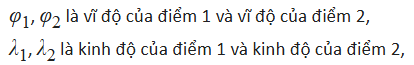

In [9]:
# Công thức tính khoảng cách giữa kinh độ, vĩ độ này đến kinh độ, vĩ độ khác (Distance)
def haversine(lati1, longi1, lati2, longi2):
    R = 6371
    # Chuyển đổi độ sang radian
    lati1, longi1, lati2, longi2 = map(math.radians, [lati1, longi1, lati2, longi2])
    dlati = lati2 - lati1
    dlongi = longi2 - longi1

    a = math.sin(dlati / 2) ** 2 + math.cos(lati1) * math.cos(lati2) * math.sin(dlongi / 2) ** 2
    distance = 2 * R * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return round(distance, 2)

In [10]:
# Tính khoảng cách từ Restaurant --> Delivery_location, Time_of_Day
def add_columns(data_frame):
    data_frame['Time_of_Day'] = data_frame['Time_Orderd'].dt.hour.apply(get_time)

    for i in range(len(data_frame)):
        data_frame.loc[i, 'distance'] = haversine(data_frame.loc[i, 'Restaurant_latitude'], 
                                                  data_frame.loc[i, 'Restaurant_longitude'], 
                                                  data_frame.loc[i, 'Delivery_location_latitude'], 
                                                  data_frame.loc[i, 'Delivery_location_longitude'])
    

In [11]:
df_copy = df.copy()
replace_columns_value(df)
convert_dtype(df)
add_columns(df)
df = df.drop(["Time_Orderd" ,"Restaurant_latitude", "Restaurant_longitude", "Delivery_location_latitude", "Delivery_location_longitude"], axis=1)
df.head()

C:\Users\linh3\AppData\Local\Temp\ipykernel_12120\2090078558.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_frame['Time_Orderd'] = pd.to_datetime(data_frame['Time_Orderd'])


,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,Festival,City,Time_taken(min),Time_of_Day,distance
0,37,4.9,conditions Sunny,High,2,Snack,motorcycle,No,Urban,24,noon,3.03
1,34,4.5,conditions Stormy,Jam,2,Snack,scooter,No,Metropolitian,33,evening,20.18
2,23,4.4,conditions Sandstorms,Low,0,Drinks,motorcycle,No,Urban,26,morning,1.55
3,38,4.7,conditions Sunny,Medium,0,Buffet,motorcycle,No,Metropolitian,21,afternoon,7.79
4,32,4.6,conditions Cloudy,High,1,Snack,scooter,No,Metropolitian,30,afternoon,6.21


In [12]:
df.describe()

,Delivery_person_Age,Delivery_person_Ratings,Vehicle_condition,Time_taken(min),distance
count,42260.000000,42260.000000,42260.000000,42260.000000,42260.000000
mean,29.597089,4.633897,0.997042,26.475982,26.834864
std,5.762773,0.315244,0.817655,9.335128,298.865142
min,20.000000,2.500000,0.000000,10.000000,1.470000
25%,25.000000,4.500000,0.000000,19.000000,4.660000
50%,30.000000,4.700000,1.000000,26.000000,9.220000
75%,35.000000,4.900000,2.000000,33.000000,13.680000
max,39.000000,5.000000,2.000000,54.000000,6884.730000


In [13]:
df = df[df['distance'] <= 32]
df.describe()

,Delivery_person_Age,Delivery_person_Ratings,Vehicle_condition,Time_taken(min),distance
count,42112.000000,42112.000000,42112.000000,42112.000000,42112.000000
mean,29.597241,4.633914,0.996889,26.480124,9.758666
std,5.763837,0.315267,0.817581,9.337474,5.608783
min,20.000000,2.500000,0.000000,10.000000,1.470000
25%,25.000000,4.500000,0.000000,19.000000,4.660000
50%,30.000000,4.700000,1.000000,26.000000,9.220000
75%,35.000000,4.900000,2.000000,33.000000,13.680000
max,39.000000,5.000000,2.000000,54.000000,20.970000


In [14]:
unique_columns = ["Weatherconditions", "Road_traffic_density", "Vehicle_condition", "Type_of_order", "Type_of_vehicle", "Festival", "City"]
for column in unique_columns:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}':", unique_values, "\n")

Unique values in 'Weatherconditions': ['conditions Sunny' 'conditions Stormy' 'conditions Sandstorms'
 'conditions Cloudy' 'conditions Fog' 'conditions Windy'] 

Unique values in 'Road_traffic_density': ['High' 'Jam' 'Low' 'Medium'] 

Unique values in 'Vehicle_condition': [2 0 1] 

Unique values in 'Type_of_order': ['Snack' 'Drinks' 'Buffet' 'Meal'] 

Unique values in 'Type_of_vehicle': ['motorcycle' 'scooter' 'electric_scooter'] 

Unique values in 'Festival': ['No' 'Yes'] 

Unique values in 'City': ['Urban' 'Metropolitian' 'Semi-Urban'] 



### 3) Data visualization

C:\Users\linh3\AppData\Local\Temp\ipykernel_12120\2676864262.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Road_traffic_density", y="Time_taken(min)", data=df, palette="viridis")


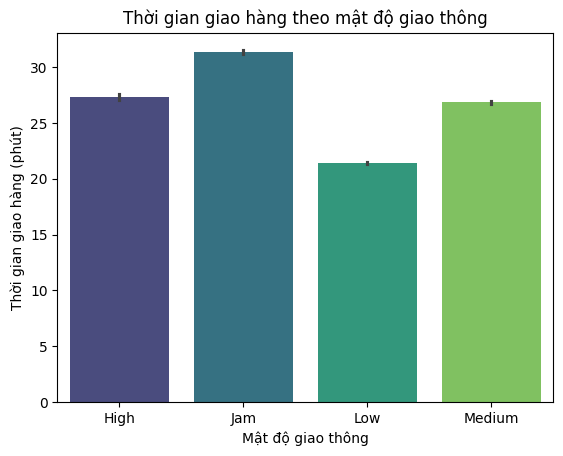

In [15]:
# Mối quan hệ giữa mật độ giao thông và thời gian giao hàng
sns.barplot(x="Road_traffic_density", y="Time_taken(min)", data=df, palette="viridis")
plt.title("Thời gian giao hàng theo mật độ giao thông")
plt.xlabel("Mật độ giao thông")
plt.ylabel("Thời gian giao hàng (phút)")
plt.show()

C:\Users\linh3\AppData\Local\Temp\ipykernel_12120\2751617906.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Festival", y="Time_taken(min)", data=df, palette="Set2")


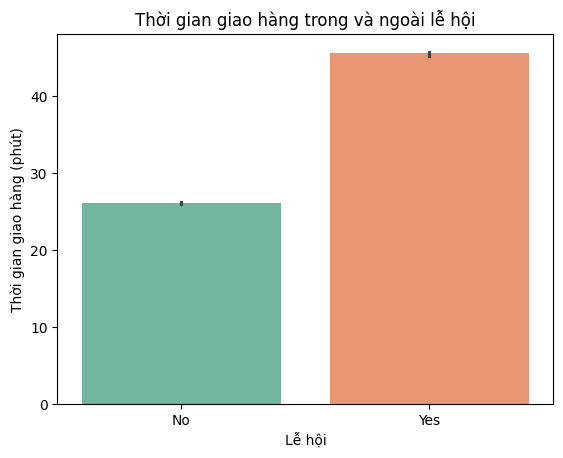

In [16]:
# Tác động của lễ hội đến thời gian giao hàng
sns.barplot(x="Festival", y="Time_taken(min)", data=df, palette="Set2")
plt.title("Thời gian giao hàng trong và ngoài lễ hội")
plt.xlabel("Lễ hội")
plt.ylabel("Thời gian giao hàng (phút)")
plt.show()

C:\Users\linh3\AppData\Local\Temp\ipykernel_12120\2052330055.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Weatherconditions", y="Time_taken(min)", data=weather_avg, palette="coolwarm")


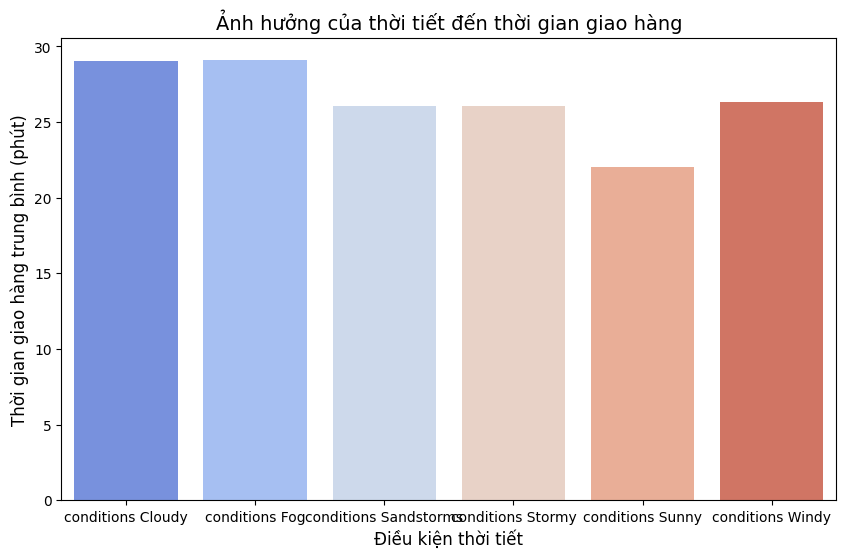

In [17]:
# Ảnh hưởng của điều kiện thời tiết đến thời gian giao
plt.figure(figsize=(10, 6))
weather_avg = df.groupby("Weatherconditions")["Time_taken(min)"].mean().reset_index()
sns.barplot(x="Weatherconditions", y="Time_taken(min)", data=weather_avg, palette="coolwarm")
plt.title("Ảnh hưởng của thời tiết đến thời gian giao hàng", fontsize=14)
plt.xlabel("Điều kiện thời tiết", fontsize=12)
plt.ylabel("Thời gian giao hàng trung bình (phút)", fontsize=12)
plt.show()

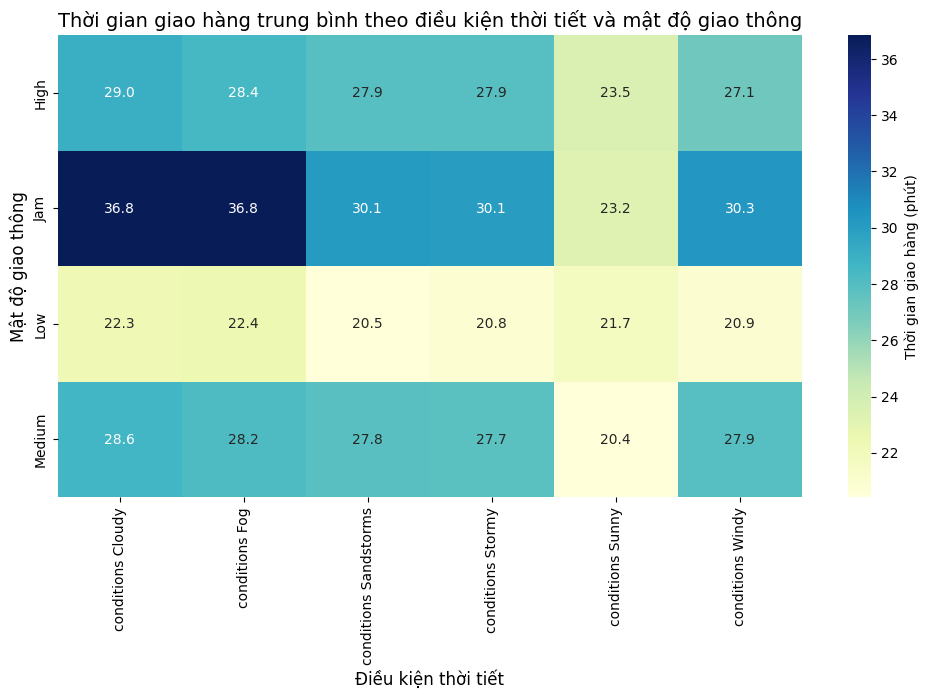

In [18]:
# Phân bố thời gian giao hàng
plt.figure(figsize=(12, 6))
heatmap_data = df.pivot_table(index="Road_traffic_density", columns="Weatherconditions", values="Time_taken(min)", aggfunc="mean")
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".1f", cbar_kws={'label': 'Thời gian giao hàng (phút)'})
plt.title("Thời gian giao hàng trung bình theo điều kiện thời tiết và mật độ giao thông", fontsize=14)
plt.xlabel("Điều kiện thời tiết", fontsize=12)
plt.ylabel("Mật độ giao thông", fontsize=12)
plt.show()

C:\Users\linh3\AppData\Local\Temp\ipykernel_12120\1865639580.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Vehicle_condition", y="Time_taken(min)", data=vehicle_avg, palette="coolwarm")


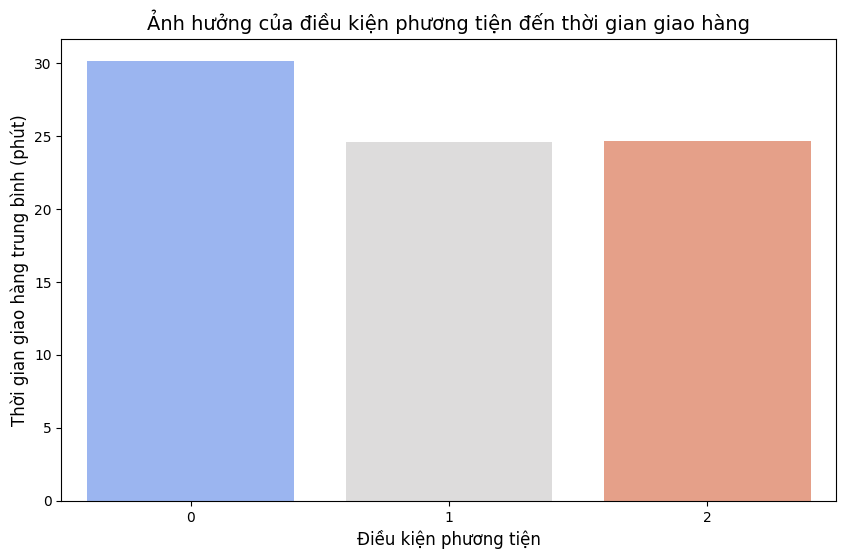

In [19]:
# Ảnh hưởng của điều kiện phương tiện đến thời gian giao hàng
plt.figure(figsize=(10, 6))
vehicle_avg = df.groupby("Vehicle_condition")["Time_taken(min)"].mean().reset_index()
sns.barplot(x="Vehicle_condition", y="Time_taken(min)", data=vehicle_avg, palette="coolwarm")
plt.title("Ảnh hưởng của điều kiện phương tiện đến thời gian giao hàng", fontsize=14)
plt.xlabel("Điều kiện phương tiện", fontsize=12)
plt.ylabel("Thời gian giao hàng trung bình (phút)", fontsize=12)
plt.show()

### 4) Data preparation

In [54]:
df.head(1)

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,Festival,City,Time_taken(min),Time_of_Day,distance
0,37,4.9,conditions Sunny,High,2,Snack,motorcycle,No,Urban,24,noon,3.03


In [63]:
# Cắt dữ liệu test trước cho phần deploy
train_deploy, test_deploy = train_test_split(df_copy, test_size=0.2, random_state=10)
# Ghi thành file csv
test_deploy.to_csv('datasets/data_test_deploy.csv', index=False)
test_deploy

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,Festival,City,Time_taken(min)
16438,24,4.7,9.988483,76.295211,10.028483,76.335211,12:15:00,conditions Stormy,High,1,Buffet,scooter,No,Urban,(min) 11
39891,23,4.7,12.979096,77.640625,13.009096,77.670625,19:30:00,conditions Sandstorms,Jam,0,Snack,motorcycle,No,Metropolitian,(min) 30
4808,29,4.7,13.026279,80.174568,13.056279,80.204568,19:55:00,conditions Cloudy,Jam,2,Drinks,scooter,No,Metropolitian,(min) 25
6972,36,4.8,22.748060,75.893400,22.778060,75.923400,23:40:00,conditions Sandstorms,Low,2,Drinks,electric_scooter,No,Metropolitian,(min) 25
32838,38,4,11.008638,76.984311,11.078638,77.054311,19:20:00,conditions Windy,Jam,0,Buffet,motorcycle,No,Metropolitian,(min) 49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38847,25,4.9,19.091458,72.827808,19.131458,72.867808,12:10:00,conditions Stormy,High,0,Snack,motorcycle,No,Metropolitian,(min) 29
3407,30,3.8,15.561295,73.749478,15.651295,73.839478,23:25:00,conditions Fog,Low,1,Drinks,scooter,No,Urban,(min) 35
34003,35,4.6,0.000000,0.000000,0.010000,0.010000,09:40:00,conditions Cloudy,Low,2,Buffet,scooter,No,Urban,(min) 15
7427,31,4.9,10.961850,76.971082,10.991850,77.001082,18:10:00,conditions Cloudy,Medium,2,Buffet,scooter,No,Metropolitian,(min) 17


In [16]:
# Hàm mã hóa các label string
label_encoders = {}
column_encoders = [ "Weatherconditions", "Road_traffic_density", "Type_of_order", "Type_of_vehicle", 
                    "Festival", "City", "Time_of_Day"]

def f_label_encoders(data_frame, columns):
    for column in columns:
        encoder = LabelEncoder()
        data_frame[column] = encoder.fit_transform(data_frame[column])
        label_encoders[column] = encoder

f_label_encoders(df, column_encoders)
# Lưu lại để khi deploy dùng lại
joblib.dump(label_encoders, 'checkpoints/label_encoders.pkl')
print(label_encoders)

{'Weatherconditions': LabelEncoder(), 'Road_traffic_density': LabelEncoder(), 'Type_of_order': LabelEncoder(), 'Type_of_vehicle': LabelEncoder(), 'Festival': LabelEncoder(), 'City': LabelEncoder(), 'Time_of_Day': LabelEncoder()}


In [17]:
# Hàm chuẩn hóa dữ liệu float
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, MinMaxScaler

label_scaler = {}
column_scalers = [ "Delivery_person_Age", "Delivery_person_Ratings", "Time_taken(min)", "distance"]

def f_scaler(data_frame, columns):
    for column in columns:
        scaler  = MaxAbsScaler()
        data_frame[column] = scaler .fit_transform(data_frame[[column]])
        label_scaler[column] = scaler 

f_scaler(df, column_scalers)
joblib.dump(label_scaler, 'checkpoints/label_scalers.pkl')
print(label_scaler)

{'Delivery_person_Age': MaxAbsScaler(), 'Delivery_person_Ratings': MaxAbsScaler(), 'Time_taken(min)': MaxAbsScaler(), 'distance': MaxAbsScaler()}


In [18]:
df.head()

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,Festival,City,Time_taken(min),Time_of_Day,distance
0,0.948718,0.98,4,0,2,3,1,0,2,0.444444,3,0.144492
1,0.871795,0.90,3,1,2,3,2,0,0,0.611111,1,0.962327
2,0.589744,0.88,2,2,0,1,1,0,2,0.481481,2,0.073915
3,0.974359,0.94,4,3,0,0,1,0,0,0.388889,0,0.371483
4,0.820513,0.92,0,0,1,3,2,0,0,0.555556,0,0.296137


In [19]:
# Cắt dữ liệu
columns_X = ["Delivery_person_Age", "Delivery_person_Ratings", "Weatherconditions", "Road_traffic_density", 
             "Vehicle_condition", "Type_of_order", "Type_of_vehicle", "Festival", "City", "Time_of_Day", "distance"]
X = df[columns_X]
y = df["Time_taken(min)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train[:2]

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,Festival,City,Time_of_Day,distance
29512,0.717949,0.94,4,2,2,1,2,0,2,2,0.146400
6509,0.897436,0.90,2,1,2,1,0,0,2,1,0.450167


### 5) Model and Metric

In [20]:
# Các giá trị metric
def score_metric(y_true, y_pred):
    score_mean_ae = mean_absolute_error(y_true, y_pred)
    score_mse = mean_squared_error(y_true, y_pred)
    score_median_ae = median_absolute_error(y_true, y_pred)
    score_r2 = r2_score(y_true, y_pred)

    return [score_mean_ae, score_mse, score_median_ae, score_r2]

#### 5.1) Model test

In [21]:
# Danh sách các mô hình test
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
}

score_metric_models = []

for name, model in models.items():
    y_pred = model.fit(X_train, y_train).predict(X_test)
    metrics = score_metric(y_test, y_pred)
    score_metric_models.append((name, *metrics))

score_metric_models = pd.DataFrame(score_metric_models, columns=["Model", "Mean AE", "MSE", "Median AE", "R2 Score"])
score_metric_models

,Model,Mean AE,MSE,Median AE,R2 Score
0,Linear Regression,0.098893,0.015258,0.083947,0.478748
1,Ridge Regression,0.098900,0.015257,0.083962,0.478770
2,Lasso Regression,0.137693,0.029273,0.121000,-0.000058
3,Random Forest,0.056578,0.004843,0.049357,0.834536
4,Gradient Boosting,0.064448,0.006474,0.055222,0.778821
5,XGBoost,0.064272,0.006453,0.054890,0.779530


#### 5.2) Predict 1 record

In [22]:
print(y_test[:1])
X_test[:1] # Lấy record có index 41300


41300    0.462963
Name: Time_taken(min), dtype: float64


,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,Festival,City,Time_of_Day,distance
41300,0.641026,0.92,2,1,2,1,2,0,0,1,0.592275


In [23]:
df_copy.loc[41300]

Delivery_person_Age                               25
Delivery_person_Ratings                          4.6
Restaurant_latitude                        13.066762
Restaurant_longitude                       80.251865
Delivery_location_latitude                 13.146762
Delivery_location_longitude                80.331865
Time_Orderd                                 19:50:00
Weatherconditions              conditions Sandstorms
Road_traffic_density                            Jam 
Vehicle_condition                                  2
Type_of_order                                Drinks 
Type_of_vehicle                             scooter 
Festival                                         No 
City                                  Metropolitian 
Time_taken(min)                             (min) 25
Name: 41300, dtype: object

In [24]:
data_test = pd.DataFrame( {
    "Delivery_person_Age": ["25"],
    "Delivery_person_Ratings": ["4.6"],
    "Restaurant_latitude": [13.066762],
    "Restaurant_longitude": [80.251865],
    "Delivery_location_latitude": [13.146762],
    "Delivery_location_longitude": [80.331865],
    "Time_Orderd": ["19:50:00"],
    "Weatherconditions": ["conditions Sandstorms"],
    "Road_traffic_density": ["Jam"],
    "Vehicle_condition": [2],
    "Type_of_order": ["Drinks"],
    "Type_of_vehicle": ["scooter"],
    "Festival": ["No"],
    "City": ["Metropolitian"],
    "Time_taken(min)": ["(min) 25"]
})
# Tiền xử lý
replace_columns_value(data_test)
convert_dtype(data_test)
add_columns(data_test)
data_test = data_test.drop(["Time_Orderd" ,"Restaurant_latitude", "Restaurant_longitude", "Delivery_location_latitude", "Delivery_location_longitude"], axis=1)
data_test

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,Festival,City,Time_taken(min),Time_of_Day,distance
0,25,4.6,conditions Sandstorms,Jam,2,Drinks,scooter,No,Metropolitian,25,evening,12.42


In [28]:
# # mã hóa label theo label_encoders và chuẩn hóa theo label_scaler
column_encoders = [ "Weatherconditions", "Road_traffic_density", "Type_of_order", "Type_of_vehicle", 
                    "Festival", "City", "Time_of_Day"]

column_scalers = [ "Delivery_person_Age", "Delivery_person_Ratings", "Time_taken(min)", "distance"]

for column in column_encoders:
    data_test[column] = label_encoders[column].transform(data_test[column])

for column in column_scalers:
    data_test[column] = label_scaler[column].transform(data_test[column].values.reshape(-1, 1))

data_test

c:\Users\linh3\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MaxAbsScaler was fitted with feature names
  warnings.warn(
c:\Users\linh3\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MaxAbsScaler was fitted with feature names
  warnings.warn(
c:\Users\linh3\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MaxAbsScaler was fitted with feature names
  warnings.warn(
c:\Users\linh3\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MaxAbsScaler was fitted with feature names
  warnings.warn(


,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,Festival,City,Time_taken(min),Time_of_Day,distance
0,0.641026,0.92,2,1,2,1,2,0,0,0.462963,1,0.592275


In [37]:
# model = RandomForestRegressor(n_estimators=100, max_depth=10)
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
# model =  XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)

pred_scaler = model.fit(X_train, y_train).predict(data_test[columns_X])
pred_actually = label_scaler["Time_taken(min)"].inverse_transform(pred_scaler.reshape(-1, 1))

print("Predict scaler:", pred_scaler) # Thực tế là: 0.462963 
print("Predict actually:", pred_actually) # Thục tế là: (min) 25 


Predict scaler: [0.41872431]
Predict actually: [[22.61111263]]


### 6) Save Model and deploy flask, streamlit

In [39]:
# joblib.dump(model, 'checkpoints/model_XGBRegress.pkl')

['checkpoints/model_XGBRegress.pkl']